In [1]:
from SDP_interaction_inference.constraints import Constraint
from SDP_interaction_inference import optimization
from SDP_interaction_inference.dataset import Dataset
from SDP_interaction_inference.correlation import Correlation
from SDP_interaction_inference import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import scipy
import tqdm
from copy import deepcopy
import matplotlib.patches
import corner
import plotly
import plotly.graph_objects as go

# Model Free Investigation

## Data Loading

In [2]:
# read fibroblast transcript counts
data_FIB = pd.read_csv("./Data/GSE151334_FIB_counts_thresh.csv", index_col=0)

# load capture
beta = np.loadtxt("./Capture/beta_FIB.txt")

# load RNA types
biotypes_dict = json.load(open("./Biotypes/biotypes_FIB.json"))

# select indices of protein coding mRNA and non-coding miRNA
pcRNA_indices = [idx for idx, btype in enumerate(biotypes_dict.values()) if btype == "protein_coding"]
miRNA_indices = [idx for idx, btype in enumerate(biotypes_dict.values()) if btype == "miRNA"]

# separate data
data_FIB_pcRNA = data_FIB.iloc[pcRNA_indices]
data_FIB_miRNA = data_FIB.iloc[miRNA_indices]

# amounts: see './Biotypes/updated-biotypes.ipynb' for full pie chart of types
print(f"Total of {data_FIB.shape[0]} genes with mean > 1 present \nSelected {data_FIB_miRNA.shape[0]} non-coding miRNA \nSelected {data_FIB_pcRNA.shape[0]} protein coding (mRNA)")

Total of 11747 genes with mean > 1 present 
Selected 19 non-coding miRNA 
Selected 9296 protein coding (mRNA)


## Setup functions

In [3]:
def construct_dataset(mirna_sample, mrna_dataset, beta, resamples=1000):

    # size
    gene_pairs, cells = mrna_dataset.shape

    # construct paired count dataframe
    counts_df = pd.DataFrame(
        index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
        columns = [f"Cell-{j}" for j in range(cells)]
    )

    # fill with pairs
    for i in range(gene_pairs):
        gene_i = mirna_sample
        gene_j = mrna_dataset.iloc[i]
        gene_pair_ij = list(zip(gene_i, gene_j))
        counts_df.iloc[i] = gene_pair_ij

    # construct dataset object
    data = Dataset()
    data.count_dataset = counts_df
    data.cells = cells
    data.gene_pairs = gene_pairs

    # settings
    data.resamples = resamples

    # set capture
    data.beta = beta

    return data

In [4]:
def birth_death_interacting_test(dataset, d_bd, d_me, d_sd, **kwargs):

    # Interacting birth death
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        moment_equations=True,
        factorization=False
    )
    opt_BD_int = optimization.BirthDeathOptimization(
        dataset,
        d_bd=d_bd,
        d_me=d_me,
        d_sd=d_sd,
        constraints=constraints,
        printing=False,
        silent=True,
        fixed=[(3, 1)],
        K=None,
        **kwargs
    )
    opt_BD_int.analyse_dataset()

    # extract results
    status = [solution['status'] for solution in opt_BD_int.result_dict.values()]
    times  = [solution['time'] for solution in opt_BD_int.result_dict.values()]
    cuts   = [solution['cuts'] for solution in opt_BD_int.result_dict.values()]
    correlation = [solution['correlation'] for solution in opt_BD_int.result_dict.values()]

    # collect
    data = {
        'status': status,
        'times': times,
        'cuts': cuts,
        'correlation': correlation,
        'model': opt_BD_int
    }

    return data

## Setup results

### Construct

In [5]:
# load MF independence test results
independent_MF_df = pd.read_csv("./Results/independent_MF.csv", index_col=0)

# select miRNA
miRNA = "MIR199A2"

# select dependent mRNA (d = 2 so small number)
miRNA_results = independent_MF_df[f"{miRNA}_d2_c95_status"]
mask_dep = (miRNA_results == "INFEASIBLE")
mRNA_dep = list(miRNA_results[mask_dep].index)
print(len(mRNA_dep))

# restrict further to first 100
mRNA = mRNA_dep[:100]

242


In [33]:
# dataframe to store results
BD_interacting_df = pd.DataFrame(
    index=mRNA
)

### Load

In [7]:
#MF_independent_df = pd.read_csv("Results/independent_MF.csv", index_col=0)
#MF_interacting_df = pd.read_csv("Results/interacting_MF.csv", index_col=0)

### Save

In [8]:
#MF_independent_df.to_csv("Results/independent_MF.csv")
#MF_interacting_df.to_csv("Results/interacting_MF.csv")

## Running

### c = 95%

In [31]:
# construct dataset of miRNA paired with mRNA
dataset_SDP = construct_dataset(data_FIB_miRNA.loc[miRNA], data_FIB_pcRNA.loc[mRNA], beta)

# bootstrap
dataset_SDP.confidence = 0.95
dataset_SDP.bootstrap(d=6, tqdm_disable=False)

100%|██████████| 100/100 [00:06<00:00, 14.72it/s]


In [34]:
# order settings
order_list = [
    (i, j, k) for i in [3, 4] for j in [3, 4] for k in [3, 4] 
]

# loop
for d_bd, d_me, d_sd in order_list:

    print(f"Order (d_bd, d_me, d_sd) = ({d_bd}, {d_me}, {d_sd})")

    # BD interacting test
    BD_int_c95 = birth_death_interacting_test(dataset_SDP, d_bd, d_me, d_sd, time_limit=30, total_time_limit=30)

    # display results
    print(np.unique(BD_int_c95['status'], return_counts=True))

    # store results on dataframe
    BD_interacting_df[f'{miRNA}_d{d_bd}{d_me}{d_sd}_c95_status'] = BD_int_c95['status']
    BD_interacting_df[f'{miRNA}_d{d_bd}{d_me}{d_sd}_c95_times'] = BD_int_c95['times']
    BD_interacting_df[f'{miRNA}_d{d_bd}{d_me}{d_sd}_c95_cuts'] = BD_int_c95['cuts']
    BD_interacting_df[f'{miRNA}_d{d_bd}{d_me}{d_sd}_c95_correlation'] = BD_int_c95['correlation']

    # save dataframe
    BD_interacting_df.to_csv("Results/interacting_BD.csv") # Uncomment when running

Order (d_bd, d_me, d_sd) = (3, 3, 3)


100%|██████████| 100/100 [00:05<00:00, 18.55it/s]


(array(['INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([ 3, 97]))
Order (d_bd, d_me, d_sd) = (3, 3, 4)


100%|██████████| 100/100 [00:21<00:00,  4.67it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([70,  3, 27]))
Order (d_bd, d_me, d_sd) = (3, 4, 3)


100%|██████████| 100/100 [00:24<00:00,  4.16it/s]


(array(['INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([ 3, 97]))
Order (d_bd, d_me, d_sd) = (3, 4, 4)


100%|██████████| 100/100 [03:47<00:00,  2.27s/it]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL', 'TOTAL_TIME_LIMIT'],
      dtype='<U16'), array([ 1,  3, 95,  1]))
Order (d_bd, d_me, d_sd) = (4, 3, 3)


100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


(array(['INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([ 3, 97]))
Order (d_bd, d_me, d_sd) = (4, 3, 4)


100%|██████████| 100/100 [00:27<00:00,  3.69it/s]


(array(['INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([ 3, 97]))
Order (d_bd, d_me, d_sd) = (4, 4, 3)


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


(array(['INFEASIBLE', 'OPTIMAL', 'TIME_LIMIT'], dtype='<U10'), array([ 3, 96,  1]))
Order (d_bd, d_me, d_sd) = (4, 4, 4)


100%|██████████| 100/100 [02:27<00:00,  1.47s/it]

(array(['INFEASIBLE', 'OPTIMAL', 'TIME_LIMIT'], dtype='<U10'), array([ 3, 94,  3]))


### c = 50%

In [36]:
# construct dataset of miRNA paired with mRNA
dataset_SDP = construct_dataset(data_FIB_miRNA.loc[miRNA], data_FIB_pcRNA.loc[mRNA], beta)

# bootstrap
dataset_SDP.confidence = 0.5
dataset_SDP.bootstrap(d=6, tqdm_disable=False)

100%|██████████| 100/100 [00:06<00:00, 14.64it/s]


In [37]:
# order settings
order_list = [
    (i, j, k) for i in [3, 4] for j in [3, 4] for k in [3, 4] 
]

# loop
for d_bd, d_me, d_sd in order_list:

    print(f"Order (d_bd, d_me, d_sd) = ({d_bd}, {d_me}, {d_sd})")

    # BD interacting test
    BD_int_c50 = birth_death_interacting_test(dataset_SDP, d_bd, d_me, d_sd, time_limit=30, total_time_limit=30)

    # display results
    print(np.unique(BD_int_c50['status'], return_counts=True))

    # store results on dataframe
    BD_interacting_df[f'{miRNA}_d{d_bd}{d_me}{d_sd}_c50_status'] = BD_int_c50['status']
    BD_interacting_df[f'{miRNA}_d{d_bd}{d_me}{d_sd}_c50_times'] = BD_int_c50['times']
    BD_interacting_df[f'{miRNA}_d{d_bd}{d_me}{d_sd}_c50_cuts'] = BD_int_c50['cuts']
    BD_interacting_df[f'{miRNA}_d{d_bd}{d_me}{d_sd}_c50_correlation'] = BD_int_c50['correlation']

    # save dataframe
    BD_interacting_df.to_csv("Results/interacting_BD.csv") # Uncomment when running

Order (d_bd, d_me, d_sd) = (3, 3, 3)


100%|██████████| 100/100 [00:04<00:00, 20.09it/s]


(array(['INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([26, 74]))
Order (d_bd, d_me, d_sd) = (3, 3, 4)


100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


(array(['CUT_LIMIT', 'INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([56, 26, 18]))
Order (d_bd, d_me, d_sd) = (3, 4, 3)


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


(array(['INFEASIBLE', 'OPTIMAL', 'TIME_LIMIT'], dtype='<U10'), array([25, 74,  1]))
Order (d_bd, d_me, d_sd) = (3, 4, 4)


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


(array(['INFEASIBLE', 'OPTIMAL', 'TIME_LIMIT'], dtype='<U10'), array([25, 74,  1]))
Order (d_bd, d_me, d_sd) = (4, 3, 3)


100%|██████████| 100/100 [00:06<00:00, 14.46it/s]


(array(['INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([27, 73]))
Order (d_bd, d_me, d_sd) = (4, 3, 4)


100%|██████████| 100/100 [00:09<00:00, 10.32it/s]


(array(['INFEASIBLE', 'OPTIMAL'], dtype='<U10'), array([27, 73]))
Order (d_bd, d_me, d_sd) = (4, 4, 3)


100%|██████████| 100/100 [12:12<00:00,  7.32s/it]


(array(['INFEASIBLE', 'OPTIMAL', 'TIME_LIMIT'], dtype='<U10'), array([49, 27, 24]))
Order (d_bd, d_me, d_sd) = (4, 4, 4)


100%|██████████| 100/100 [12:53<00:00,  7.73s/it]


(array(['INFEASIBLE', 'OPTIMAL', 'TIME_LIMIT'], dtype='<U10'), array([49, 26, 25]))


## Results

In [44]:
# set colours for all plots
plot_colours = {
    "OPTIMAL": "green",
    "INFEASIBLE": "red",
    "CUT_LIMIT": "blue",
    "TIME_LIMIT": "orange",
    "TOTAL_TIME_LIMIT": "pink",
    "NUMERIC": "black"
}

In [45]:
BD_interacting_df

,MIR199A2_d333_c95_status,MIR199A2_d333_c95_times,MIR199A2_d333_c95_cuts,MIR199A2_d333_c95_correlation,MIR199A2_d334_c95_status,MIR199A2_d334_c95_times,MIR199A2_d334_c95_cuts,MIR199A2_d334_c95_correlation,MIR199A2_d343_c95_status,MIR199A2_d343_c95_times,...,MIR199A2_d434_c50_cuts,MIR199A2_d434_c50_correlation,MIR199A2_d443_c50_status,MIR199A2_d443_c50_times,MIR199A2_d443_c50_cuts,MIR199A2_d443_c50_correlation,MIR199A2_d444_c50_status,MIR199A2_d444_c50_times,MIR199A2_d444_c50_cuts,MIR199A2_d444_c50_correlation
ACAP3,OPTIMAL,0.000,0,-0.101575,CUT_LIMIT,0.088001,100,NaN,OPTIMAL,0.307,...,2,-0.097226,OPTIMAL,0.005,0,-0.111695,OPTIMAL,0.015,2,-0.111942
ACOT13,OPTIMAL,0.002,0,-0.191582,CUT_LIMIT,0.099999,100,NaN,OPTIMAL,0.970,...,2,-0.225448,INFEASIBLE,0.012,0,NaN,INFEASIBLE,0.004,0,NaN
ACP6,OPTIMAL,0.000,2,-0.086344,CUT_LIMIT,0.043000,100,NaN,OPTIMAL,0.206,...,3,-0.102426,INFEASIBLE,0.062,0,NaN,INFEASIBLE,0.079,0,NaN
ADRB1,OPTIMAL,0.000,3,-0.057701,CUT_LIMIT,0.060000,100,NaN,OPTIMAL,0.272,...,0,NaN,INFEASIBLE,0.006,0,NaN,INFEASIBLE,0.017,0,NaN
AKT1,OPTIMAL,0.000,0,-0.151904,CUT_LIMIT,0.077000,100,NaN,OPTIMAL,0.248,...,2,-0.165864,TIME_LIMIT,30.006,0,NaN,TIME_LIMIT,30.006,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KCTD6,OPTIMAL,0.000,0,-0.120595,OPTIMAL,0.061000,97,-0.120595,OPTIMAL,0.000,...,0,NaN,INFEASIBLE,0.000,0,NaN,INFEASIBLE,0.000,0,NaN
KIAA1671,OPTIMAL,0.000,0,-0.091228,CUT_LIMIT,0.036000,100,NaN,OPTIMAL,0.000,...,2,-0.085578,TIME_LIMIT,30.004,0,NaN,TIME_LIMIT,30.004,0,NaN
KIF13B,OPTIMAL,0.000,0,-0.093937,CUT_LIMIT,0.056000,100,NaN,OPTIMAL,0.135,...,2,-0.079264,OPTIMAL,0.000,0,-0.113686,OPTIMAL,0.008,1,-0.115219
KIF3A,OPTIMAL,0.000,1,-0.134577,CUT_LIMIT,0.038000,100,NaN,OPTIMAL,0.006,...,2,-0.139416,TIME_LIMIT,30.006,0,NaN,TIME_LIMIT,30.006,0,NaN


In [67]:
def order_comparison_plot(dataframe, order_list, c, time_limit):

    # subplots
    m, n = 3, len(order_list)
    fig, axs = plt.subplots(m, n, figsize=(len(order_list) * 3, 6))

    # for each order
    for i, (d_bd, d_me, d_sd) in enumerate(order_list):
        
        # get data
        status_list = dataframe[f'{miRNA}_d{d_bd}{d_me}{d_sd}_c{c}_status']
        status, counts = np.unique(status_list, return_counts=True)
        times = dataframe[f'{miRNA}_d{d_bd}{d_me}{d_sd}_c{c}_times']
        cuts = dataframe[f'{miRNA}_d{d_bd}{d_me}{d_sd}_c{c}_cuts']
        colors = [plot_colours[name] for name in status]

        # plot
        wedges, texts = axs[0, i].pie(
            counts,
            labels=[f"{round(100 * count / dataframe.shape[0], 1)}%" for count in counts],
            colors=colors,
            startangle=90,
            counterclock=False,
            rotatelabels=False
        )
        axs[0, i].set_title(f"({d_bd}, {d_me}, {d_sd})")
        for text, color in zip(texts, colors):
            text.set_color(color)
        axs[1, i].hist(times)
        axs[2, i].hist(cuts)

    axs[0, 0].set_ylabel("Status")
    axs[1, 0].set_ylabel("Times")
    axs[2, 0].set_ylabel("Cuts")

    # title
    plt.suptitle(f"Effects of decoupled orders (d_bd, d_me, d_sd): c = {c}%, time_limit = {time_limit}s")
    plt.tight_layout()
    plt.show()

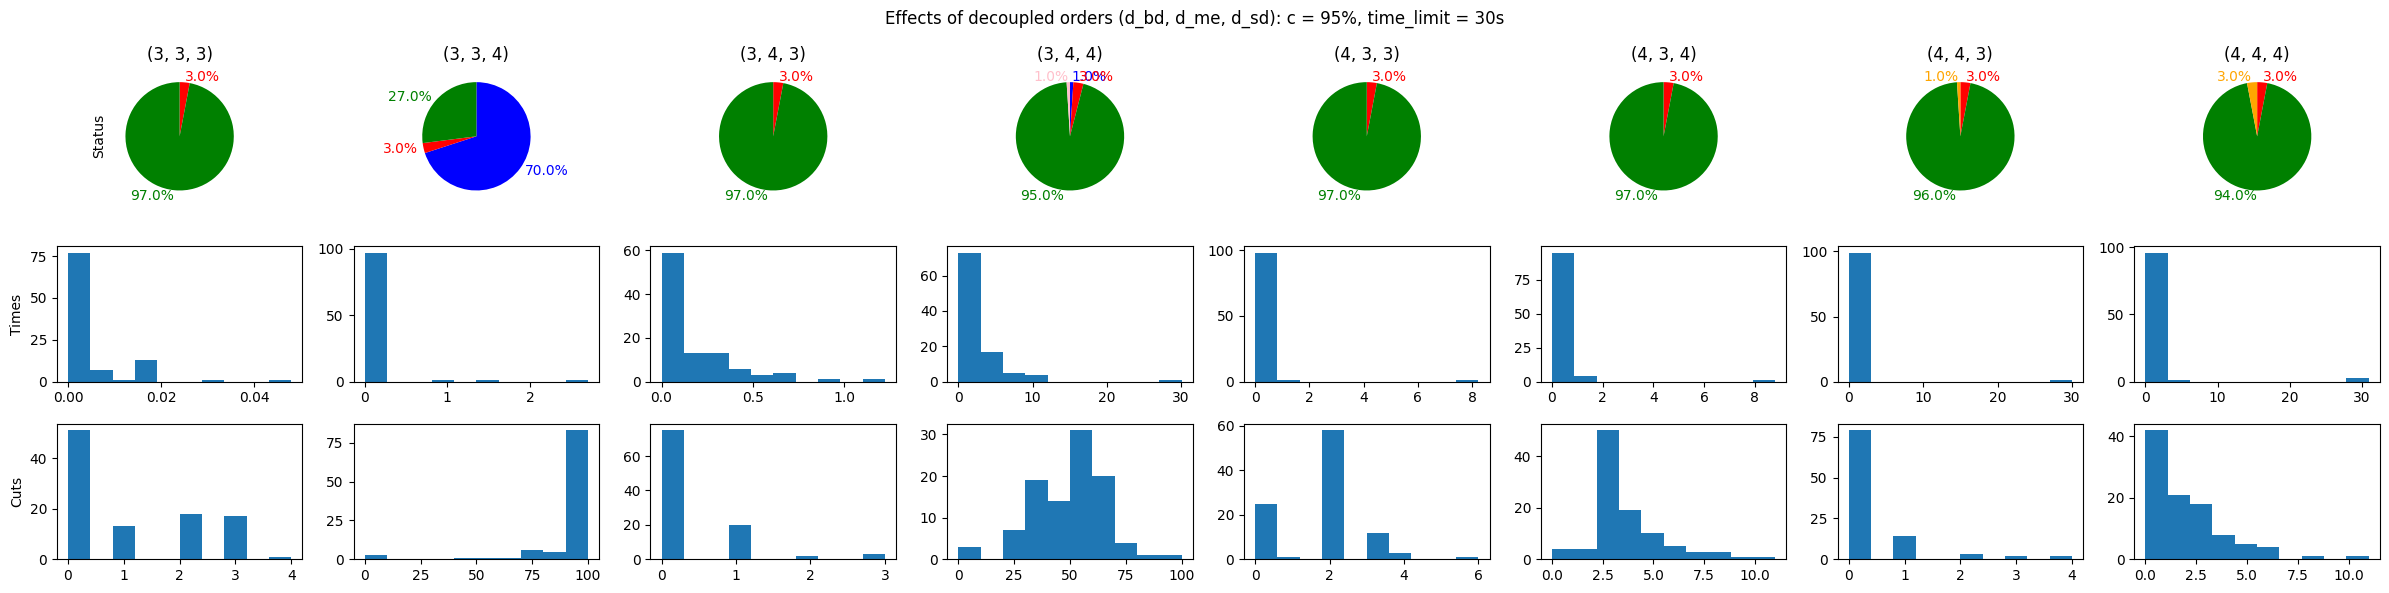

In [68]:
order_comparison_plot(BD_interacting_df, order_list, 95, 30)

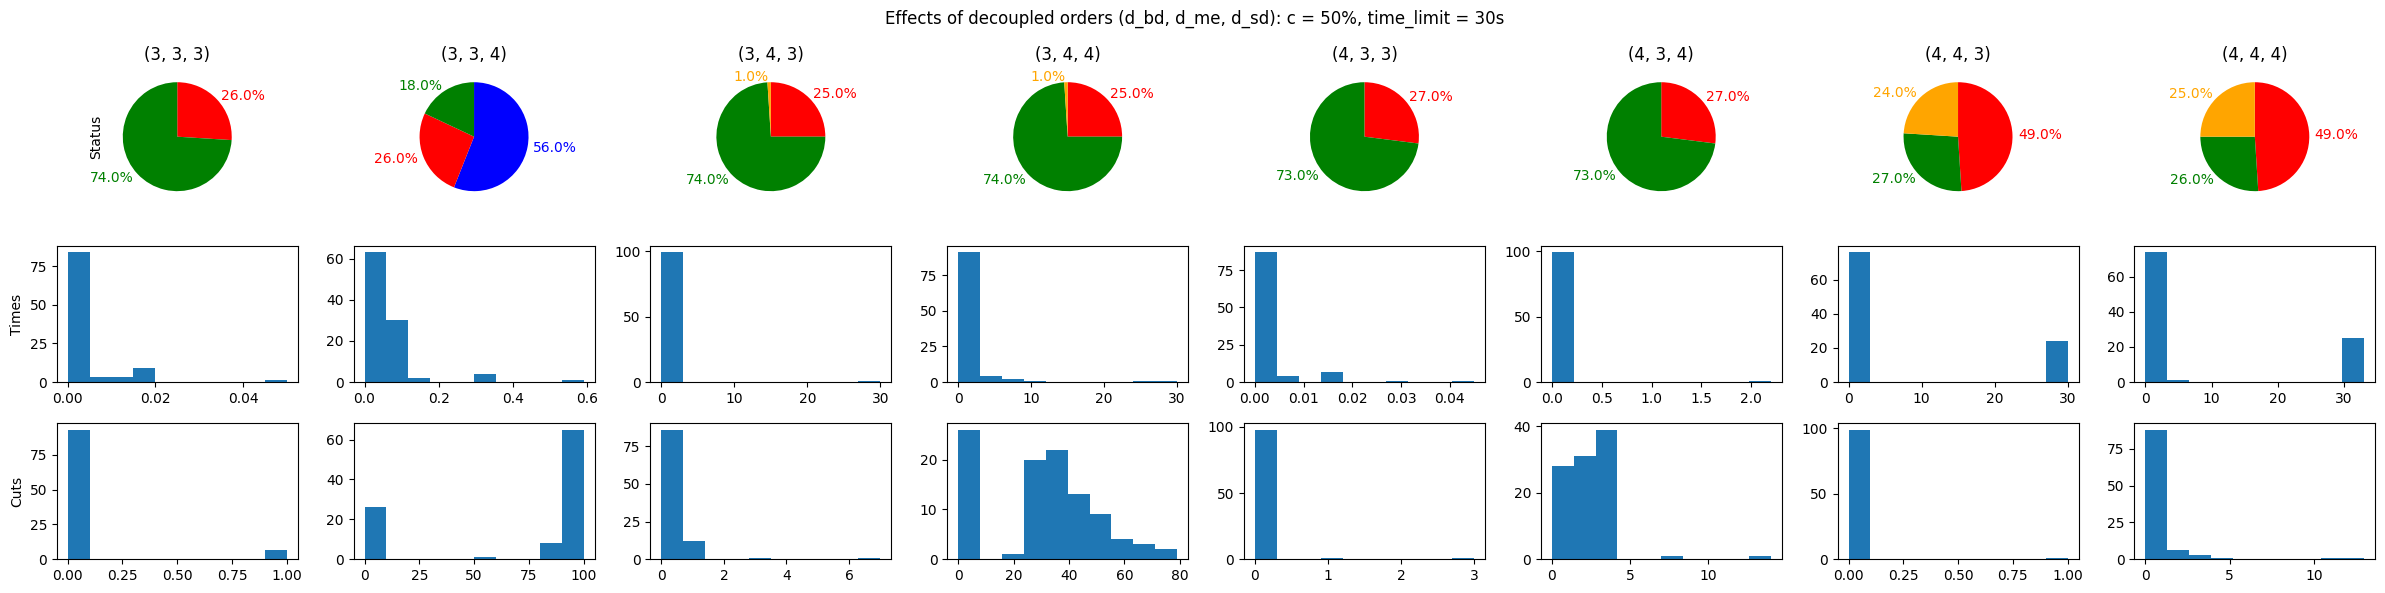

In [69]:
order_comparison_plot(BD_interacting_df, order_list, 50, 30)